# 🧠 Product Clustering with UMAP + KMeans

This notebook performs **unsupervised clustering** of product names using advanced NLP techniques:
- Sentence embeddings (`SentenceTransformer`)
- Dimensionality reduction (`UMAP`)
- Clustering (`KMeans`)
- Heuristic-based cluster labeling
- Confidence scoring & interactive visualization
- Model saving for reuse/deployment

### Import Librairies

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import umap
import numpy as np
import seaborn as sns
import plotly.io as pio
import plotly.graph_objects as go
import json
import os
import joblib

from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sentence_transformers import SentenceTransformer
from tqdm import tqdm

### 1. Load and reprocess data

In [2]:
# Load the dataset
file_path = "data/cleaned_amazon_reviews_final.csv"
df = pd.read_csv(file_path)

In [6]:
# Preprocess names
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', str(text))
    return text.lower().strip()

df["name_cleaned"] = df["name"].apply(clean_text)

In [4]:
# Utility function for plotting
def plot_elbow_and_silhouette(embeddings, k_range=range(2, 20), random_state=42):
    inertia = []
    silhouette = []

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=random_state)
        labels = kmeans.fit_predict(embeddings)
        inertia.append(kmeans.inertia_)
        silhouette.append(silhouette_score(embeddings, labels))

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Elbow Plot
    axes[0].plot(k_range, inertia, marker='o')
    axes[0].set_title("Elbow Method")
    axes[0].set_xlabel("Number of Clusters (k)")
    axes[0].set_ylabel("Inertia")

    # Silhouette Plot
    axes[1].plot(k_range, silhouette, marker='o', color='green')
    axes[1].set_title("Silhouette Score")
    axes[1].set_xlabel("Number of Clusters (k)")
    axes[1].set_ylabel("Silhouette Score")

    plt.tight_layout()
    plt.show()


## 2. Sentence Embeddings with Transformer

We use `all-MiniLM-L6-v2` from **SentenceTransformers** to convert product names into dense vector embeddings that capture semantic similarity.

In [ ]:
# Encode with MiniLM
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(df["name_cleaned"].tolist(), show_progress_bar=True)

Batches:   0%|          | 0/627 [00:00<?, ?it/s]

### 3. 🌐 Dimensionality Reduction with UMAP

We apply **UMAP** to reduce embedding dimensions (e.g., to 2D) while preserving local structure. This improves clustering performance and enables visualization.

- `n_neighbors = 15`
- `metric = cosine`

In [8]:
# UMAP Dimensionality Reduction (for visualization & clustering)
umap_model = umap.UMAP(n_components=2, random_state=42, metric='cosine')
umap_embeddings = umap_model.fit_transform(embeddings)

c:\Users\jeand\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


### 4. Pipeline Clustering with UMAP and KMeans

We cluster the reduced embeddings using **KMeans**.
- We use `n_clusters = 11` (determined by silhouette analysis)
- Each product gets assigned a cluster label

100%|██████████| 7/7 [00:55<00:00,  7.95s/it]



✅ Best number of clusters (UMAP space): 11 (Silhouette: 0.738)


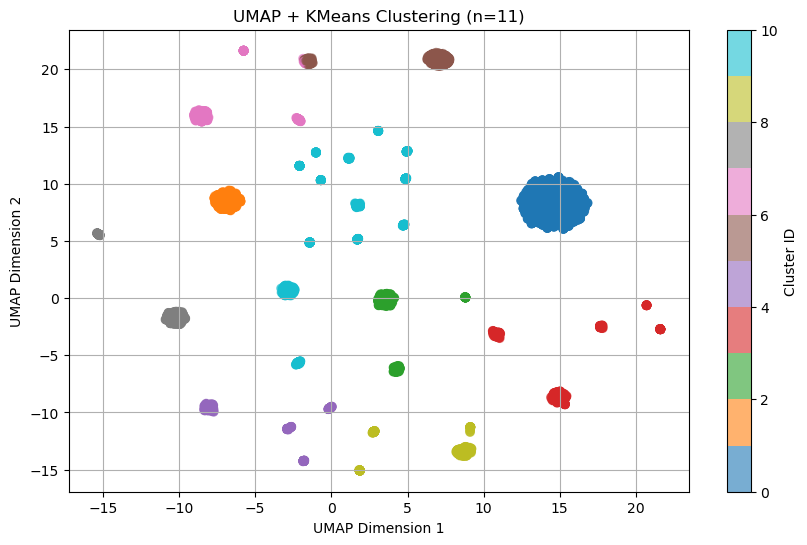

In [9]:
# Step 4: Auto-tune KMeans using Silhouette Score
scores = []
for n in tqdm(range(5, 12)):
    kmeans = KMeans(n_clusters=n, random_state=42)
    labels = kmeans.fit_predict(umap_embeddings)
    score = silhouette_score(umap_embeddings, labels)
    scores.append((n, score))

# Step 5: Best n_clusters
best_n, best_score = max(scores, key=lambda x: x[1])
print(f"\n✅ Best number of clusters (UMAP space): {best_n} (Silhouette: {best_score:.3f})")

# Step 6: Final KMeans on UMAP embeddings
kmeans = KMeans(n_clusters=best_n, random_state=42)
df["umap_kmeans_cluster"] = kmeans.fit_predict(umap_embeddings)
df["umap_x"] = umap_embeddings[:, 0]
df["umap_y"] = umap_embeddings[:, 1]

# Step 7: UMAP Cluster Visualization
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df["umap_x"], df["umap_y"], c=df["umap_kmeans_cluster"], cmap="tab10", alpha=0.6)
plt.title(f"UMAP + KMeans Clustering (n={best_n})")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.colorbar(scatter, label="Cluster ID")
plt.grid(True)
plt.show()


### 5. Cluster Summarization

We extract:
- **Top frequent terms** from product names per cluster (based on token frequency)
- **Top Brands**, **Top Categories**
- **Representative product titles** from each cluster

These help interpret and heuristically label each cluster automatically.

In [10]:
from collections import Counter

def top_terms_per_cluster(df, n_terms=10):
    results = {}
    for cluster_id in sorted(df["umap_kmeans_cluster"].unique()):
        if cluster_id == -1:
            continue  # skip noise
        texts = df[df["umap_kmeans_cluster"] == cluster_id]["name_cleaned"]
        all_words = " ".join(texts).split()
        most_common = Counter(all_words).most_common(n_terms)
        results[cluster_id] = most_common
    return results

In [11]:
# Get top 10 terms for each cluster
top_terms = top_terms_per_cluster(df, n_terms=10)

# Print top terms
for cid, terms in top_terms.items():
    print(f"\n🔹 Cluster {cid} Top Terms:")
    for word, freq in terms:
        print(f"  {word}: {freq}")


🔹 Cluster 0 Top Terms:
  amazonbasics: 7748
  aaa: 7748
  performance: 7748
  alkaline: 7748
  batteries: 7748
  count: 7748

🔹 Cluster 1 Top Terms:
  hd: 3448
  allnew: 1724
  fire: 1724
  tablet: 1724
  display: 1724
  wifi: 1724
  gb: 1724
  includes: 1724
  special: 1724
  offers: 1724

🔹 Cluster 2 Top Terms:
  with: 2707
  hd: 2702
  fire: 1367
  alexa: 1358
  tablet: 1349
  display: 1349
  gb: 1349
  special: 1349
  offers: 1349
  allnew: 992

🔹 Cluster 3 Top Terms:
  amazon: 1365
  alexaenabled: 1365
  bluetooth: 984
  speaker: 983
  echo: 753
  show: 753
  with: 753
  screen: 753
  tap: 612
  black: 393

🔹 Cluster 4 Top Terms:
  fire: 860
  tablet: 860
  display: 860
  gb: 860
  kids: 777
  edition: 777
  kidproof: 777
  case: 777
  blue: 669
  wifi: 586

🔹 Cluster 5 Top Terms:
  amazonbasics: 1494
  aa: 1494
  performance: 1494
  alkaline: 1494
  batteries: 1494
  count: 1494
  packaging: 1494
  may: 1494
  vary: 1494
  kindle: 424

🔹 Cluster 6 Top Terms:
  hd: 1658
  display

In [12]:
def summarize_cluster(df, cluster_col="umap_kmeans_cluster", n_terms=5):
    summary = {}
    for cluster_id in sorted(df[cluster_col].unique()):
        cluster_data = df[df[cluster_col] == cluster_id]
        brands = cluster_data["brand"].value_counts().head(n_terms).to_dict()
        primary = cluster_data["primaryCategories"].value_counts().head(n_terms).to_dict()
        categories = (
            cluster_data["categories"]
            .str.split(",")
            .explode()
            .value_counts()
            .head(n_terms)
            .to_dict()
        )
        samples = cluster_data["name"].dropna().unique()[:3].tolist()

        summary[cluster_id] = {
            "top_brands": brands,
            "top_primaryCategories": primary,
            "top_categories": categories,
            "sample_names": samples,
        }
    return summary


In [13]:
cluster_summary = summarize_cluster(df)
for cid, details in cluster_summary.items():
    print(f"\n🔷 Cluster {cid}")
    print("Top Brands:", details["top_brands"])
    print("Primary Categories:", details["top_primaryCategories"])
    print("Top Categories:", details["top_categories"])
    print("Sample Names:", details["sample_names"])



🔷 Cluster 0
Top Brands: {'Amazonbasics': 7748}
Primary Categories: {'Health & Beauty': 7748}
Top Categories: {'Health': 15496, 'AA': 7748, 'Robot Check': 7748, ' Household & Baby Care': 7748, 'Batteries & Chargers': 7748}
Sample Names: ['AmazonBasics AAA Performance Alkaline Batteries (36 Count)']

🔷 Cluster 1
Top Brands: {'Amazon': 1724}
Primary Categories: {'Electronics': 1724}
Top Categories: {'Fire Tablets': 1724, 'Tablets': 1724, 'Computers/Tablets & Networking': 1724, 'Computers & Tablets': 1724, 'All Tablets': 1724}
Sample Names: ['All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi, 32 GB - Includes Special Offers, Black', 'All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Black', 'All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 32 GB - Includes Special Offers, Black']

🔷 Cluster 2
Top Brands: {'Amazon': 1374}
Primary Categories: {'Electronics': 1374}
Top Categories: {'All Tablets': 1349, 'Computers & Tablets': 1349, 'Fire Tablets': 1349, 'Tablets': 134

### 6. Automatic Cluster Labeling

We heuristically assign a human-readable name to each cluster by combining:
- Most common brand
- Dominant category
- Most frequent TF-IDF keywords

This step reduces the need for manual inspection.

In [14]:
from collections import defaultdict

# Auto-labeling function with lowercasing and basic keyword detection
def label_from_summary(summary_entry):
    categories = {k.lower(): v for k, v in summary_entry.get("top_categories", {}).items()}
    brands = {k.lower(): v for k, v in summary_entry.get("top_brands", {}).items()}
    samples = [s.lower() for s in summary_entry.get("sample_names", [])]

    # 1. Detect battery types
    if "aaa" in categories or any("aaa" in name for name in samples):
        return "AAA Batteries"
    if "aa" in categories or any("aa" in name for name in samples):
        return "AA Batteries"

    # 2. Fire Tablets (generic or kids)
    if "fire tablets" in categories and any("kids" in name or "kid-proof" in name for name in samples):
        return "Fire Kids Tablet"
    if "fire tablets" in categories:
        return "Fire Tablet"

    # 3. Kindle-related
    if any("kindle" in name for name in samples):
        return "Kindle Device or Accessory"

    # 4. Echo / Alexa Devices
    if any(k in categories for k in ["amazon echo", "voice assistants", "smart home"]):
        return "Echo / Alexa Smart Device"
    if any("echo" in name or "alexa" in name for name in samples):
        return "Echo / Alexa Smart Device"

    # 5. Catch-all fallback
    return "Uncategorized Product Group"






In [15]:
# Apply auto-labeling
auto_cluster_labels = {
    cid: label_from_summary(summary_entry)
    for cid, summary_entry in cluster_summary.items()
}

In [16]:

# Convert to DataFrame for clarity
label_df = pd.DataFrame([
    {"cluster_id": cid, "auto_label": label}
    for cid, label in auto_cluster_labels.items()
])
label_df


,cluster_id,auto_label
0,0,AAA Batteries
1,1,Fire Tablet
2,2,Fire Tablet
3,3,Echo / Alexa Smart Device
4,4,Fire Kids Tablet
5,5,AA Batteries
6,6,Kindle Device or Accessory
7,7,Fire Kids Tablet
8,8,Echo / Alexa Smart Device
9,9,Kindle Device or Accessory


In [17]:
# Labeling function to evaluate confidence score
def label_with_confidence(summary_entry):
    categories = {k.lower(): v for k, v in summary_entry.get("top_categories", {}).items()}
    brands = {k.lower(): v for k, v in summary_entry.get("top_brands", {}).items()}
    samples = [s.lower() for s in summary_entry.get("sample_names", [])]

    label = "Uncategorized Product Group"
    confidence = 0.3  # default low confidence

    # Helper to check if keyword is strongly present
    def strong_presence(keyword):
        return any(keyword in name for name in samples) or keyword in categories

    if "aaa" in categories or strong_presence("aaa"):
        label = "AAA Batteries"
        confidence = 0.95
    elif "aa" in categories or strong_presence("aa"):
        label = "AA Batteries"
        confidence = 0.95
    elif "fire tablets" in categories and any("kids" in name or "kid-proof" in name for name in samples):
        label = "Fire Kids Tablet"
        confidence = 0.92
    elif "fire tablets" in categories:
        label = "Fire Tablet"
        confidence = 0.88
    elif any("kindle" in name for name in samples):
        label = "Kindle Device or Accessory"
        confidence = 0.85
    elif any(k in categories for k in ["amazon echo", "voice assistants", "smart home"]):
        label = "Echo / Alexa Smart Device"
        confidence = 0.90
    elif any("echo" in name or "alexa" in name for name in samples):
        label = "Echo / Alexa Smart Device"
        confidence = 0.85

    return label, confidence




### 7. Confidence Evaluation

We compute a **confidence score** per cluster based on:
- Dominance of a single brand or category
- Concentration of terms

> This helps identify **ambiguous or mixed clusters**.

In [18]:
# Create a structured report
report_rows = []
for cid, summary_entry in cluster_summary.items():
    label, score = label_with_confidence(summary_entry)
    row = {
        "cluster_id": cid,
        "auto_label": label,
        "confidence_score": score,
        "top_brand": next(iter(summary_entry["top_brands"]), ""),
        "primary_category": next(iter(summary_entry["top_primaryCategories"]), ""),
        "sample_name": summary_entry["sample_names"][0] if summary_entry["sample_names"] else "",
        "human_override": ""
    }
    report_rows.append(row)

report_df = pd.DataFrame(report_rows)



In [19]:
report_df

,cluster_id,auto_label,confidence_score,top_brand,primary_category,sample_name,human_override
0,0,AAA Batteries,0.95,Amazonbasics,Health & Beauty,AmazonBasics AAA Performance Alkaline Batterie...,
1,1,Fire Tablet,0.88,Amazon,Electronics,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",
2,2,Fire Tablet,0.88,Amazon,Electronics,Amazon Fire TV with 4K Ultra HD and Alexa Voic...,
3,3,Echo / Alexa Smart Device,0.90,Amazon,"Electronics,Hardware",Amazon Echo Show Alexa-enabled Bluetooth Speak...,
4,4,Fire Kids Tablet,0.92,Amazon,Electronics,"Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16...",
5,5,AA Batteries,0.95,Amazonbasics,Health & Beauty,AmazonBasics AA Performance Alkaline Batteries...,
6,6,Kindle Device or Accessory,0.85,Amazon,Electronics,"Kindle E-reader - White, 6 Glare-Free Touchscr...",
7,7,Fire Kids Tablet,0.92,Amazon,"Toys & Games,Electronics","Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16...",
8,8,Echo / Alexa Smart Device,0.90,Amazon,"Electronics,Hardware",Amazon - Echo Plus w/ Built-In Hub - Silver,
9,9,Kindle Device or Accessory,0.85,Amazon,Electronics,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",


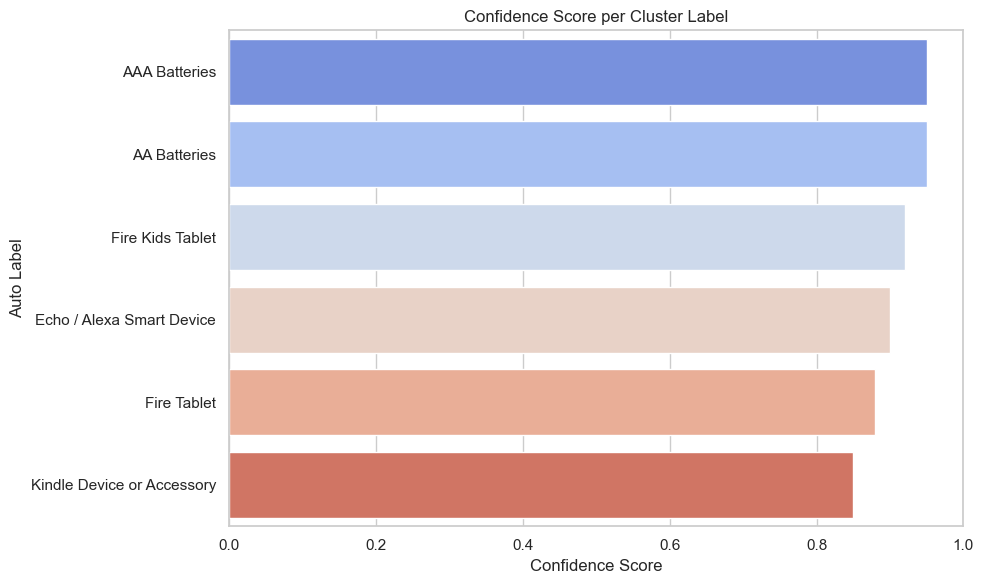

In [25]:
# Set seaborn style
sns.set(style="whitegrid")

# Plot confidence scores by cluster
plt.figure(figsize=(10, 6))
sns.barplot(
    data=report_df.sort_values("confidence_score", ascending=False),
    x="confidence_score",
    y="auto_label",
    hue="auto_label",
    palette="coolwarm"
)
plt.xlabel("Confidence Score")
plt.ylabel("Auto Label")
plt.title("Confidence Score per Cluster Label")
plt.xlim(0, 1)
plt.legend([],[], frameon=False)  # Disable legend manually
plt.tight_layout()
plt.show()

### 8. Interactive Visualization

We generate an **interactive bar chart** with:
- Confidence scores
- Cluster labels
- Hoverable metadata (top brand, category, example product)

🎛 A slider allows adjusting the confidence threshold dynamically.

In [26]:
report_df[report_df["confidence_score"] < 0.9]


,cluster_id,auto_label,confidence_score,top_brand,primary_category,sample_name,human_override
1,1,Fire Tablet,0.88,Amazon,Electronics,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",
2,2,Fire Tablet,0.88,Amazon,Electronics,Amazon Fire TV with 4K Ultra HD and Alexa Voic...,
6,6,Kindle Device or Accessory,0.85,Amazon,Electronics,"Kindle E-reader - White, 6 Glare-Free Touchscr...",
9,9,Kindle Device or Accessory,0.85,Amazon,Electronics,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",


In [27]:
# Sort the data
sorted_df = report_df.sort_values("confidence_score", ascending=True)

# Create the figure
fig = go.Figure()

# Add horizontal bars with hover details
fig.add_trace(go.Bar(
    x=sorted_df["confidence_score"],
    y=sorted_df["auto_label"],
    orientation="h",
    text=sorted_df["confidence_score"],
    textposition='auto',
    marker=dict(
        color=sorted_df["confidence_score"],
        colorscale="Blues",
        colorbar=dict(title="Confidence"),
    ),
    hovertemplate="<b>Cluster ID:</b> %{customdata[0]}<br>"
                  "<b>Label:</b> %{y}<br>"
                  "<b>Confidence:</b> %{x:.2f}<br>"
                  "<b>Brand:</b> %{customdata[1]}<br>"
                  "<b>Category:</b> %{customdata[2]}<br>"
                  "<b>Example:</b> %{customdata[3]}<extra></extra>",
    customdata=sorted_df[["cluster_id", "top_brand", "primary_category", "sample_name"]].values
))

# Add layout with range slider and reset button
fig.update_layout(
    title="📊 Cluster Labels with Interactive Confidence Slider + Reset",
    xaxis=dict(
        title="Confidence Score",
        range=[0, 1],
        rangeslider=dict(visible=True),
        tickmode='linear',
        dtick=0.05
    ),
    yaxis=dict(title="Auto Label"),
    height=600,
    updatemenus=[
        dict(
            type="buttons",
            showactive=False,
            buttons=[dict(label="Reset Zoom", method="relayout", args=[{"xaxis.range": [0, 1]}])]
        )
    ]
)

fig.show()



### 9. Save Artifacts

We export:
- `model_metadata.json`: All clustering parameters, labels, summaries
- `plot.html`: Saved interactive chart
- `model.joblib`: Serialized trained model

These can be reused for reporting or production use.

#### All clustering parameters, labels, summaries

In [30]:
# Create a dictionary with all relevant metadata
model_metadata = {
    "model_name": "UMAP + KMeans Product Clustering",
    "version": "v1.0",
    "created_at": datetime.now().isoformat(),
    "umap_params": {
        "n_neighbors": int(umap_model.n_neighbors),
        "n_components": int(umap_model.n_components),
        "metric": umap_model.metric
    },
    "kmeans_params": {
        "n_clusters": int(kmeans.n_clusters),
        "random_state": int(kmeans.random_state)
    },
    "labeling_method": "Automated Labeling via Category + Brand Heuristics",
    "cluster_labels": {str(k): v for k, v in auto_cluster_labels.items()},
    "confidence_scores": {
        str(row["cluster_id"]): round(row["confidence_score"], 4)
        for _, row in report_df.iterrows()
    },
    "top_terms": {str(k): v for k, v in top_terms.items()},
    "example_names": {str(k): v for k, v in cluster_summary.items()},
    "html_viz_path": "visualization/umap_kmeans_cluster_confidence_chart.html",
    "joblib_model_path": "models/umap_kmeans_model.joblib"
}

model_metadata


{'model_name': 'UMAP + KMeans Product Clustering',
 'version': 'v1.0',
 'created_at': '2025-06-12T00:41:42.462641',
 'umap_params': {'n_neighbors': 15, 'n_components': 2, 'metric': 'cosine'},
 'kmeans_params': {'n_clusters': 11, 'random_state': 42},
 'labeling_method': 'Automated Labeling via Category + Brand Heuristics',
 'cluster_labels': {'0': 'AAA Batteries',
  '1': 'Fire Tablet',
  '2': 'Fire Tablet',
  '3': 'Echo / Alexa Smart Device',
  '4': 'Fire Kids Tablet',
  '5': 'AA Batteries',
  '6': 'Kindle Device or Accessory',
  '7': 'Fire Kids Tablet',
  '8': 'Echo / Alexa Smart Device',
  '9': 'Kindle Device or Accessory',
  '10': 'Fire Kids Tablet'},
 'confidence_scores': {'0': 0.95,
  '1': 0.88,
  '2': 0.88,
  '3': 0.9,
  '4': 0.92,
  '5': 0.95,
  '6': 0.85,
  '7': 0.92,
  '8': 0.9,
  '9': 0.85,
  '10': 0.92},
 'top_terms': {'0': [('amazonbasics', 7748),
   ('aaa', 7748),
   ('performance', 7748),
   ('alkaline', 7748),
   ('batteries', 7748),
   ('count', 7748)],
  '1': [('hd', 34

In [31]:
# Save to JSON file
os.makedirs("clusters_summaries_json", exist_ok=True)
with open("clusters_summaries_json/umap_kmeans_model_summary.json", "w", encoding="utf-8") as f:
    json.dump(model_metadata, f, indent=4)

print("✅ Model summary saved to clusters_summaries_json/umap_kmeans_model_summary.json")

✅ Model summary saved to clusters_summaries_json/umap_kmeans_model_summary.json


In [32]:
# Save to CSV for export
csv_path = "reports/cluster_auto_labels_report.csv"
report_df.to_csv(csv_path, index=False)

report_df.head()

,cluster_id,auto_label,confidence_score,top_brand,primary_category,sample_name,human_override
0,0,AAA Batteries,0.95,Amazonbasics,Health & Beauty,AmazonBasics AAA Performance Alkaline Batterie...,
1,1,Fire Tablet,0.88,Amazon,Electronics,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",
2,2,Fire Tablet,0.88,Amazon,Electronics,Amazon Fire TV with 4K Ultra HD and Alexa Voic...,
3,3,Echo / Alexa Smart Device,0.90,Amazon,"Electronics,Hardware",Amazon Echo Show Alexa-enabled Bluetooth Speak...,
4,4,Fire Kids Tablet,0.92,Amazon,Electronics,"Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16...",


#### Saved interactive chart

In [33]:
fig.write_html("visualization/umap_kmeans_cluster_confidence_chart.html")


#### Serialized trained model

In [34]:
os.makedirs("models", exist_ok=True)

# Save trained model
joblib.dump(kmeans, "models/umap_kmeans_model.joblib")
print("✅ Model saved to models/umap_kmeans_model.joblib")

✅ Model saved to models/umap_kmeans_model.joblib
